In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://dlcdn.apache.org/spark/
!wget -q https://dlcdn.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"
import findspark
findspark.init()
findspark.find()
import pyspark

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,155 kB]
Fetched 3,283 kB in 11s (286 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
37 packages can be upgraded. Run 'apt list --upgradable' to see

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql import functions as f

In [18]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .getOrCreate()
spark

In [19]:
from pyspark.sql import types as T

data_schema = T.StructType([
    T.StructField('contract_id', T.StringType(), False),
    T.StructField('timestamp', T.TimestampType(), False),
    T.StructField('value', T.DoubleType(), True),
    T.StructField('value_source', T.StringType(), False),
    T.StructField('annotations', T.StringType(), True)
])

df_raw_time_series = spark.read.format('json') \
    .schema(data_schema) \
    .load('/content/drive/MyDrive/Colab Notebooks/project/raw_time_series/json')
df_raw_time_series = spark.createDataFrame(df_raw_time_series.rdd, schema=data_schema)
df_raw_time_series.printSchema()
df_raw_time_series.show()

root
 |-- contract_id: string (nullable = false)
 |-- timestamp: timestamp (nullable = false)
 |-- value: double (nullable = true)
 |-- value_source: string (nullable = false)
 |-- annotations: string (nullable = true)

+-------------------+-------------------+--------------------+------------+--------------------+
|        contract_id|          timestamp|               value|value_source|         annotations|
+-------------------+-------------------+--------------------+------------+--------------------+
| 04_02_111 _ CHR12 |2023-01-01 06:00:00| 0.02591860654732236| measurement|{"region":"Europe...|
| 04 _02_111 _CHR12 |2023-01-01 17:00:00| 0.07385444264936832| measurement|{"region":"Europe...|
| 04_02_111 _ CHR12 |2023-01-01 17:30:22| 0.08180149515221906| measurement|{"region":"Europe...|
| 04 _02_111 _CHR12 |2023-01-01 21:30:00| 0.08670661371854547| measurement|{"region":"Europe...|
|04 _ 02 _111_CHR12 |2023-01-02 00:30:00| 0.03597601881331959| measurement|{"region":"Europe...|
|04 

Data clean-up and info extraction progress - if ruled more than once, all values will be turned to NULL

In [20]:
region_schema = T.StructType([
    T.StructField('region', T.StringType(), False)
])

events_schema = T.StructType([
    T.StructField("events", T.StructType([
        T.StructField("EV", T.StringType()),
        T.StructField("PV", T.StringType()),
        T.StructField("BATTERY_IN", T.StringType()),
        T.StructField("BATTERY_OUT", T.StringType()),
        T.StructField("GRID_SELL", T.StringType()),
    ]))
])

df_raw_time_series = (
    df_raw_time_series
    .withColumn('contract_id',
                f.regexp_replace(f.col('contract_id'), ' ', ''))
    .withColumn('value_source',
                f.when(f.col('value').isNull(), 'missing').otherwise(f.col('value_source')))
    .withColumn('timestamp',
                f.from_unixtime(f.round(f.unix_timestamp('timestamp') / (15 * 60)) * (15 * 60)))
    .withColumn('timestamp',
                f.date_format('timestamp', 'yyyy-MM-dd HH:mm'))
    .withColumn('region',
                f.from_json(f.col('annotations'), region_schema).getField('region'))
    .filter(~((f.col('region').isNull()) |
            (f.trim(f.col('region')) == '') |
            (f.regexp_extract(f.col('region'), r'^[A-Za-z]+(?:[\s-][A-Za-z]+)*\/[A-Za-z]+(?:[\s-][A-Za-z]+)*$', 0) == '')))
    .withColumn('utc_date',
                f.date_format('timestamp', 'yyyy-MM-dd'))
    .withColumn("local_timestamp",
                f.from_utc_timestamp(f.col('timestamp'), f.col("region")))
    .withColumn("local_date",
                f.to_date(f.col("local_timestamp")))
    .withColumn("annotation_json",
                f.from_json(f.col("annotations"), events_schema))
    .withColumn("sent_to_ev",
                f.coalesce(f.col("annotation_json.events.EV").cast(T.DoubleType()), f.lit(0)))
    .withColumn("received_from_pv",
                f.coalesce(f.col("annotation_json.events.PV").cast(T.DoubleType()), f.lit(0)))
    .withColumn("sent_to_battery",
                f.coalesce(f.col("annotation_json.events.BATTERY_IN").cast(T.DoubleType()), f.lit(0)))
    .withColumn("received_from_battery",
                f.coalesce(f.col("annotation_json.events.BATTERY_OUT").cast(T.DoubleType()), f.lit(0)))
    .withColumn("sent_to_grid",
                f.coalesce(f.col("annotation_json.events.GRID_SELL").cast(T.DoubleType()), f.lit(0)))
    .drop("annotation_json")
    .drop("annotations")
)

df_raw_time_series.show()

+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+
|    contract_id|       timestamp|               value|value_source|       region|  utc_date|    local_timestamp|local_date|sent_to_ev|received_from_pv|sent_to_battery|received_from_battery|sent_to_grid|
+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+
|04_02_111_CHR12|2023-01-01 06:00| 0.02591860654732236| measurement|Europe/Berlin|2023-01-01|2023-01-01 07:00:00|2023-01-01|       0.0|             0.0|            0.0|                  0.0|         0.0|
|04_02_111_CHR12|2023-01-01 17:00| 0.07385444264936832| measurement|Europe/Berlin|2023-01-01|2023-01-01 18:00:00|2023-01-01|       0.0|             0.0|            0.0|                

Setting the `value_source` column in `plausability_check_failed` for unusual consumption values ​​in the database.
- the decision of high values is ​​either made with a visual analysis of the data (their visual sorting and identification or by simple or complicated aggregations) or, as bonus, through automatic learning techniques (KMeans, isolation forests).

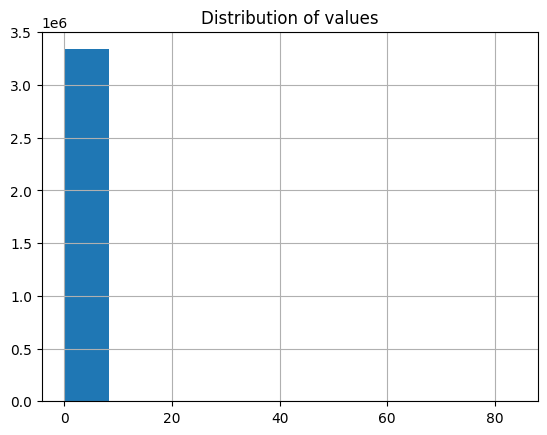

In [21]:
# histogram / density plot

df_values = df_raw_time_series.select('value').toPandas()
df_values.hist()
plt.title('Distribution of values')
plt.show()

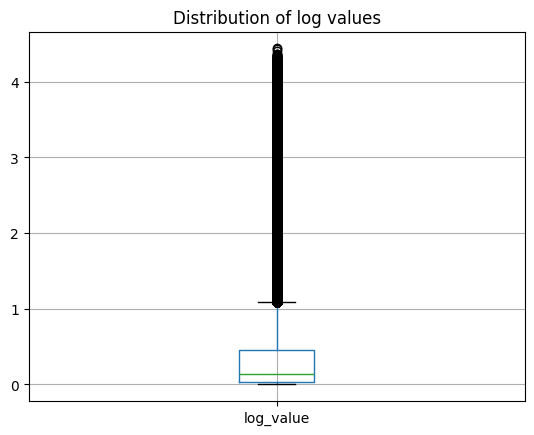

In [22]:
# log scale

df_values['log_value'] = np.log1p(df_values['value'])
df_values.boxplot(column='log_value')
plt.title('Distribution of log values')
plt.show()

In [23]:
# z-score
outlier_limit = 5

# mean and standard deviation
mean_value = df_raw_time_series.select(f.mean('value')).first()[0]
std_value = df_raw_time_series.select(f.stddev('value')).first()[0]

# z-scores and filter for outliers
print("Mean value:", mean_value)
print("Standard deviation:", std_value)
df_updated_zscore = df_raw_time_series \
      .withColumn('z_score', (f.col('value') - mean_value) / std_value) \
      .withColumn('value_source',
                  f.when(f.abs(f.col('z_score')) > outlier_limit, 'plausability_check_failed')
                  .otherwise(f.col('value_source')))

df_updated_zscore.select('contract_id', 'timestamp', 'value', 'z_score', 'value_source').show(300, truncate=False)

Mean value: 0.49049897443150375
Standard deviation: 1.528242575319825
+---------------+----------------+--------------------+--------------------+------------+
|contract_id    |timestamp       |value               |z_score             |value_source|
+---------------+----------------+--------------------+--------------------+------------+
|04_02_111_CHR12|2023-01-01 06:00|0.02591860654732236 |-0.30399648287966047|measurement |
|04_02_111_CHR12|2023-01-01 17:00|0.07385444264936832 |-0.2726298419574796 |measurement |
|04_02_111_CHR12|2023-01-01 17:30|0.08180149515221906 |-0.26742971690456535|measurement |
|04_02_111_CHR12|2023-01-01 21:30|0.08670661371854547 |-0.26422007031734085|measurement |
|04_02_111_CHR12|2023-01-02 00:30|0.03597601881331959 |-0.2974154515509838 |measurement |
|04_02_111_CHR12|2023-01-02 05:30|0.03638379308965683 |-0.29714862592858426|measurement |
|04_02_111_CHR12|2023-01-03 10:45|0.931575            |0.2886165015237777  |measurement |
|04_02_111_CHR12|2023-01-03 18

In [24]:
print("Nr. of failed plausability rows with z-score:", df_updated_zscore.filter(f.col('value_source') == 'plausability_check_failed').count())

Nr. of failed plausability rows with z-score: 10057


In [25]:
# quantile approximation - with upper quantile
quantiles = df_raw_time_series.approxQuantile('value', [0.95], 0.01)
print("Quantile threshold:", quantiles[0])

df_updated_quantile = df_raw_time_series.withColumn(
    'value_source',
    f.when(f.col('value') > quantiles[0], 'plausability_check_failed').otherwise(f.col('value_source')))
df_updated_quantile.select('contract_id', 'timestamp', 'value', 'value_source').show(300, truncate=False)

Quantile threshold: 1.661425
+---------------+----------------+--------------------+-------------------------+
|contract_id    |timestamp       |value               |value_source             |
+---------------+----------------+--------------------+-------------------------+
|04_02_111_CHR12|2023-01-01 06:00|0.02591860654732236 |measurement              |
|04_02_111_CHR12|2023-01-01 17:00|0.07385444264936832 |measurement              |
|04_02_111_CHR12|2023-01-01 17:30|0.08180149515221906 |measurement              |
|04_02_111_CHR12|2023-01-01 21:30|0.08670661371854547 |measurement              |
|04_02_111_CHR12|2023-01-02 00:30|0.03597601881331959 |measurement              |
|04_02_111_CHR12|2023-01-02 05:30|0.03638379308965683 |measurement              |
|04_02_111_CHR12|2023-01-03 10:45|0.931575            |measurement              |
|04_02_111_CHR12|2023-01-03 18:30|0.08816273670606922 |measurement              |
|04_02_111_CHR12|2023-01-04 06:30|NULL                |missing       

In [26]:
print("Nr. of failed plausability rows with 95th quantile:", df_updated_quantile.filter(f.col('value_source') == 'plausability_check_failed').count())

Nr. of failed plausability rows with 95th quantile: 177925


In [27]:
df_updated_quantile.select('contract_id', 'timestamp', 'value', 'value_source') \
  .filter(f.col('value_source') == 'plausability_check_failed') \
  .orderBy(f.col('value')) \
  .show(2000, truncate=False)

+---------------+----------------+------------------+-------------------------+
|contract_id    |timestamp       |value             |value_source             |
+---------------+----------------+------------------+-------------------------+
|10_01_147_CHR61|2023-05-23 13:00|1.661435214035643 |plausability_check_failed|
|04_02_111_CHS01|2023-03-28 15:15|1.661475114177063 |plausability_check_failed|
|10_01_147_CHR11|2023-06-14 07:15|1.661563125       |plausability_check_failed|
|04_02_111_CHR48|2023-01-26 13:00|1.6615699949852787|plausability_check_failed|
|10_01_147_CHR14|2023-05-29 13:15|1.6615875373872577|plausability_check_failed|
|04_02_111_CHR56|2023-01-25 20:45|1.661606768181765 |plausability_check_failed|
|04_02_111_CHR37|2023-01-03 17:45|1.6616157124614719|plausability_check_failed|
|04_02_111_CHS01|2023-07-12 14:30|1.661615747657321 |plausability_check_failed|
|04_02_111_CHR05|2023-03-28 15:15|1.6616465787561343|plausability_check_failed|
|10_01_147_CHR49|2023-11-06 13:30|1.6616

In [28]:
# quantile approximation - with upper and lower limits
quantiles = df_raw_time_series.approxQuantile('value', [0.05, 0.95], 0.01)
print(f"Quantile threshold interval: [{quantiles[0]}, {quantiles[1]}]")

df_updated_quantile = df_raw_time_series.withColumn(
    'value_source',
    f.when((f.col('value') > quantiles[1]) | (f.col('value') < quantiles[0]), 'plausability_check_failed').otherwise(f.col('value_source')))
df_updated_quantile.select('contract_id', 'timestamp', 'value', 'value_source').show(300, truncate=False)

Quantile threshold interval: [0.01192347194199816, 1.661425]
+---------------+----------------+--------------------+-------------------------+
|contract_id    |timestamp       |value               |value_source             |
+---------------+----------------+--------------------+-------------------------+
|04_02_111_CHR12|2023-01-01 06:00|0.02591860654732236 |measurement              |
|04_02_111_CHR12|2023-01-01 17:00|0.07385444264936832 |measurement              |
|04_02_111_CHR12|2023-01-01 17:30|0.08180149515221906 |measurement              |
|04_02_111_CHR12|2023-01-01 21:30|0.08670661371854547 |measurement              |
|04_02_111_CHR12|2023-01-02 00:30|0.03597601881331959 |measurement              |
|04_02_111_CHR12|2023-01-02 05:30|0.03638379308965683 |measurement              |
|04_02_111_CHR12|2023-01-03 10:45|0.931575            |measurement              |
|04_02_111_CHR12|2023-01-03 18:30|0.08816273670606922 |measurement              |
|04_02_111_CHR12|2023-01-04 06:30|NUL

In [29]:
print("Nr. of failed plausability rows with 5th and 95th quantile:", df_updated_quantile.filter(f.col('value_source') == 'plausability_check_failed').count())

Nr. of failed plausability rows with 5th and 95th quantile: 348871


In [30]:
# bonus: k-means
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

df_raw_time_series_km = df_raw_time_series.where(f.col('value').isNotNull()).repartition(10)

assembler = VectorAssembler(inputCols=['value'], outputCol='features')
data_assembler = assembler.transform(df_raw_time_series_km)

kmeans = KMeans(featuresCol="features", k=3)
model = kmeans.fit(data_assembler)

predictions = model.transform(data_assembler)

center = model.clusterCenters()[0]

In [31]:
def cluster_distance(vector):
  return float(vector.squared_distance(center))

df_raw_time_series_km = data_assembler \
    .withColumn('distance',
                f.udf(cluster_distance, T.DoubleType())(f.col('features')))

threshold = 5.0
df_raw_time_series_km = (
    df_raw_time_series_km \
    .withColumn('value_source',
                f.when(f.col('distance') > threshold, 'plausability_check_failed')
                .otherwise(f.col('value_source')))
)

df_raw_time_series_km.select('value_source').distinct().show()
df_raw_time_series_km.show()

+--------------------+
|        value_source|
+--------------------+
|         measurement|
|plausability_chec...|
+--------------------+

+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+-----------------+----------------+---------------+---------------------+-----------------+--------------------+-------------------+
|    contract_id|       timestamp|               value|value_source|       region|  utc_date|    local_timestamp|local_date|       sent_to_ev|received_from_pv|sent_to_battery|received_from_battery|     sent_to_grid|            features|           distance|
+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+-----------------+----------------+---------------+---------------------+-----------------+--------------------+-------------------+
|04_02_111_CHR23|2023-03-16 02:45| 0.03628830317335224| measurement|Europe/Berlin|2023-03-

In [32]:
print("Nr. of failed plausability rows with K-Means:", df_raw_time_series_km.filter(f.col('value_source') == 'plausability_check_failed').count())

Nr. of failed plausability rows with K-Means: 53044


In [33]:
# bonus: isolation forest
from sklearn.ensemble import IsolationForest

df_sample = df_raw_time_series.select('value') \
    .toPandas()

isf = IsolationForest(n_estimators=100, contamination=0.01)
isf.fit(df_sample)

df_sample['anomaly'] = isf.predict(df_sample)
anomalies = df_sample[df_sample['anomaly'] == -1]
print(anomalies)
anomalies = anomalies['value'].tolist()

df_raw_time_series_if = (
    df_raw_time_series \
    .withColumn('value_source',
                f.when(f.col('value').isin(anomalies), 'plausability_check_failed')
                .otherwise(f.col('value_source')))
)

df_raw_time_series_if.select('value_source').distinct().show()
df_raw_time_series_if.show()

             value  anomaly
432       3.012450       -1
778       6.479100       -1
1232      3.204391       -1
1370     27.177675       -1
1471      3.354841       -1
...            ...      ...
3443616   2.752964       -1
3443928   2.752962       -1
3443954   6.599160       -1
3444000   2.752780       -1
3444002   2.753070       -1

[34274 rows x 2 columns]
+--------------------+
|        value_source|
+--------------------+
|         measurement|
|             missing|
|plausability_chec...|
+--------------------+

+---------------+----------------+--------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+
|    contract_id|       timestamp|               value|value_source|       region|  utc_date|    local_timestamp|local_date|sent_to_ev|received_from_pv|sent_to_battery|received_from_battery|sent_to_grid|
+---------------+----------------+--------------------+------------+

In [34]:
print("Nr. of failed plausability rows with isolation forests:", df_raw_time_series_if.filter(f.col('value_source') == 'plausability_check_failed').count())

Nr. of failed plausability rows with isolation forests: 34274


In [35]:
df_raw_time_series = df_updated_zscore

In [36]:
# count check-up
df_raw_time_series.filter(f.col('value_source') == 'plausability_check_failed').count()

10057

Saving data with `value_source` having value `plausability_check_failed` in a separate location. The data is not removed from the data set.


In [37]:
df_raw_time_series.filter(f.col('value_source') == 'plausability_check_failed') \
  .write.mode('overwrite') \
  .json('/content/drive/MyDrive/Colab Notebooks/project/plausability_check_failed')

Setting the `value` column in NULL for the rows with `value_source` having `plausability_check_failed`.

In [38]:
df_raw_time_series = (
    df_raw_time_series
    .withColumn('value',
        f.when(f.col('value_source') == 'plausability_check_failed', None)
        .otherwise(f.col('value')))
)
df_raw_time_series \
    .filter(f.col('value_source') == 'plausability_check_failed') \
    .show(30)

+---------------+----------------+-----+--------------------+-------------+----------+-------------------+----------+----------+----------------+-----------------+---------------------+-----------------+------------------+
|    contract_id|       timestamp|value|        value_source|       region|  utc_date|    local_timestamp|local_date|sent_to_ev|received_from_pv|  sent_to_battery|received_from_battery|     sent_to_grid|           z_score|
+---------------+----------------+-----+--------------------+-------------+----------+-------------------+----------+----------+----------------+-----------------+---------------------+-----------------+------------------+
|04_02_111_CHR39|2023-01-26 13:30| NULL|plausability_chec...|Europe/Berlin|2023-01-26|2023-01-26 14:30:00|2023-01-26|     1.035|        1.294175|              0.0|                  0.0|              0.0|17.462657078496523|
|04_02_111_CHR39|2023-02-01 09:30| NULL|plausability_chec...|Europe/Berlin|2023-02-01|2023-02-01 10:30:00|20

Certain customers have a few shortcomings in consumption, some of them added to us in the previous step:

- Predicing the value `value` when it is null using the following method:

  - We first calculate the average of the last 8 weeks of the values ​​of the same day of the week at the same time, minute and second.Only the values ​​that are not missing are used from the last 8 weeks, they have the `value_source` column set on the `measurement` value.
  - we make the sum of the columns `sent_to_ev`,` sent_to_battery` and `sent_to_grid`.
  - we make the sum of the columns `received_from_pv` and `received_from_battery`.
  - we complete the `value` columns with a maximum of these 3 values.
  - Bonus, for those who want, you can also use automatic learning algorithms, such as Linear Regression, instead of calculating the average of the last 8 weeks and comparing the 2 methods.


In [39]:
# first_date = df_raw_time_series.select(f.min('local_date')).first()[0]
latest_date = f.current_timestamp()

df_mean_groups = (
  df_raw_time_series \
  .filter((f.col('timestamp') >= f.date_sub(latest_date, 56)).isNotNull() &
          (f.col('value_source') == 'measurement') &
          (f.col('value').isNotNull()))
  .groupBy(f.dayofweek('timestamp').alias('day_of_week'),
           f.hour('timestamp').alias('hour'),
           f.minute('timestamp').alias('minute'),
           f.second('timestamp').alias('second'))
  .agg(f.mean('value').alias('mean_value'))
)

df_mean_groups.show()

+-----------+----+------+------+-------------------+
|day_of_week|hour|minute|second|         mean_value|
+-----------+----+------+------+-------------------+
|          4|   6|    45|     0|0.07571914067981877|
|          4|  10|    45|     0| 0.7810519516152445|
|          4|   6|    30|     0|0.06203788444974286|
|          5|   4|    45|     0|0.03547832251187747|
|          5|  20|    15|     0|0.20014013980713635|
|          2|  22|    15|     0|0.19414055385108012|
|          1|   7|    30|     0|  1.484439342048086|
|          5|   0|    30|     0|0.06468075715437605|
|          1|  10|    45|     0| 0.7357374157053368|
|          6|  23|    30|     0|0.12584959422901068|
|          1|  17|     0|     0|0.49559566114030035|
|          2|   5|    30|     0| 0.0449143849993395|
|          6|  11|    15|     0| 0.9583975248509673|
|          4|  18|    15|     0| 0.3061404541370997|
|          2|  13|     0|     0| 1.0695520975296877|
|          3|   6|    30|     0|0.200970761790

In [40]:
df_sum_sent = (
    df_raw_time_series
    .filter((f.col("local_date") >= f.date_sub(latest_date, 56)).isNotNull())
    .groupBy(
        f.dayofweek("timestamp").alias("day_of_week"),
        f.hour("timestamp").alias("hour"),
        f.minute("timestamp").alias("minute"),
        f.second("timestamp").alias("second"),
        )
    .agg(
        f.sum("sent_to_ev").alias("sum_sent_to_ev"),
        f.sum("sent_to_battery").alias("sum_sent_to_battery"),
        f.sum("sent_to_grid").alias("sum_sent_to_grid"),
    )
)

df_sum_sent.show()

+-----------+----+------+------+------------------+-------------------+------------------+
|day_of_week|hour|minute|second|    sum_sent_to_ev|sum_sent_to_battery|  sum_sent_to_grid|
+-----------+----+------+------+------------------+-------------------+------------------+
|          4|   6|    30|     0|               0.0|                0.0|               0.0|
|          4|   6|    45|     0|               0.0|                0.0|               0.0|
|          4|  10|    45|     0|1167.8927163830647| 111.76628063140672| 564.3711754707756|
|          5|   4|    45|     0|               0.0|                0.0|               0.0|
|          5|  20|    15|     0|               0.0|                0.0|               0.0|
|          2|  22|    15|     0|               0.0|                0.0|               0.0|
|          1|   7|    30|     0|            7023.5|                0.0|               0.0|
|          5|   0|    30|     0|               0.0|                0.0|               0.0|

In [41]:
df_sum_receive = (
    df_raw_time_series
    .filter((f.col("local_date") >= f.date_sub(latest_date, 56)).isNotNull())
    .groupBy(
        f.dayofweek("timestamp").alias("day_of_week"),
        f.hour("timestamp").alias("hour"),
        f.minute("timestamp").alias("minute"),
        f.second("timestamp").alias("second"),
        )
    .agg(
        f.sum("received_from_pv").alias("sum_received_from_pv"),
        f.sum("received_from_battery").alias("sum_received_from_battery"),
    )
)

df_sum_receive.show()

+-----------+----+------+------+--------------------+-------------------------+
|day_of_week|hour|minute|second|sum_received_from_pv|sum_received_from_battery|
+-----------+----+------+------+--------------------+-------------------------+
|          4|   6|    30|     0|                 0.0|                      0.0|
|          4|   6|    45|     0|                 0.0|                      0.0|
|          4|  10|    45|     0|  2274.0455218749994|        4.745960889070456|
|          5|   4|    45|     0|                 0.0|                      0.0|
|          5|  20|    15|     0|                 0.0|         48.6860904742007|
|          2|  22|    15|     0|                 0.0|       31.542798256059783|
|          1|   7|    30|     0|                 0.0|       1433.8601065550529|
|          5|   0|    30|     0|                 0.0|                      0.0|
|          1|  10|    45|     0|   2302.465318750001|        2.253178418496248|
|          6|  23|    30|     0|        

In [42]:
df_mean_groups = (
    df_mean_groups \
    .join(df_sum_sent, on=['day_of_week', 'hour', 'minute', 'second'], how='left') \
    .withColumn('value', f.greatest(f.col('sum_sent_to_ev'), f.col('sum_sent_to_battery'), f.col('sum_sent_to_grid')))
)

df_mean_groups.show()

+-----------+----+------+------+-------------------+------------------+-------------------+------------------+------------------+
|day_of_week|hour|minute|second|         mean_value|    sum_sent_to_ev|sum_sent_to_battery|  sum_sent_to_grid|             value|
+-----------+----+------+------+-------------------+------------------+-------------------+------------------+------------------+
|          4|   6|    45|     0|0.07571914067981877|               0.0|                0.0|               0.0|               0.0|
|          4|  10|    45|     0| 0.7810519516152445|1167.8927163830647| 111.76628063140672| 564.3711754707756|1167.8927163830647|
|          4|   6|    30|     0|0.06203788444974286|               0.0|                0.0|               0.0|               0.0|
|          5|   4|    45|     0|0.03547832251187747|               0.0|                0.0|               0.0|               0.0|
|          5|  20|    15|     0|0.20014013980713635|               0.0|                0.0

In [56]:
# bonus: linear regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Imputer

df_sample = df_raw_time_series.select('value').repartition(10)
# df_sample = df_raw_time_series.where(f.col('value').isNotNull()).repartition(10)

# tip: using an imputer to take null values into consideration
imputer = Imputer(inputCols=['value'], outputCols=['value'])
df_sample = imputer.fit(df_sample).transform(df_sample)

assembler = VectorAssembler(inputCols=['value'], outputCol='features')
data_assembler = assembler.transform(df_sample)

lr = LinearRegression(featuresCol='features', labelCol='value')
model = lr.fit(data_assembler)

predictions = model.transform(data_assembler)

predictions.show()

# mean squared error
evaluator = RegressionEvaluator(labelCol='value', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
print('Mean Squared Error:', mse)

# root mean squared error
evaluator.setMetricName('rmse')
rmse = evaluator.evaluate(predictions)
print('Root Mean Squared Error:', rmse)

# mean absolute error
evaluator.setMetricName('mae')
mae = evaluator.evaluate(predictions)
print('Mean Absolute Error:', mae)

# r-square
evaluator.setMetricName('r2')
r2 = evaluator.evaluate(predictions)
print('R-square:', r2)

+-------------------+--------------------+--------------------+
|              value|            features|          prediction|
+-------------------+--------------------+--------------------+
|0.03616838439889163|[0.03616838439889...| 0.03616838439889172|
|0.07218804671856902|[0.07218804671856...|  0.0721880467185691|
|0.07743114038707587|[0.07743114038707...| 0.07743114038707595|
|  1.140257646409175| [1.140257646409175]|  1.1402576464091747|
|     3.322568316964|    [3.322568316964]|   3.322568316963999|
|0.01203612085985267|[0.01203612085985...|0.012036120859852766|
|0.07996166049606865|[0.07996166049606...| 0.07996166049606873|
| 0.1583223808066784|[0.1583223808066784]|  0.1583223808066785|
| 0.0951522720350451|[0.0951522720350451]| 0.09515227203504517|
|  0.101067948106304| [0.101067948106304]| 0.10106794810630407|
|           0.167325|          [0.167325]| 0.16732500000000008|
|           0.167325|          [0.167325]| 0.16732500000000008|
|           0.167325|          [0.167325

Calculation of `received_from_grid` value when we have all the information.
- we make the sum of the columns `sent_to_ev`, `sent_to_battery` and `sent_to_grid` and we drop the values ​​in the `received_from_pv` and `received_from_battery` columns.


In [43]:
df_received = df_raw_time_series.withColumn(
    "received_from_grid",
    f.col("sent_to_ev") + f.col("sent_to_battery") + f.col("sent_to_grid") - f.col("received_from_pv") - f.col("received_from_battery")
)

df_received.orderBy(f.col('received_from_grid').desc()).show()

+---------------+----------------+------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+------------------+------------------+
|    contract_id|       timestamp|             value|value_source|       region|  utc_date|    local_timestamp|local_date|sent_to_ev|received_from_pv|sent_to_battery|received_from_battery|sent_to_grid|           z_score|received_from_grid|
+---------------+----------------+------------------+------------+-------------+----------+-------------------+----------+----------+----------------+---------------+---------------------+------------+------------------+------------------+
|04_02_111_CHR41|2023-02-13 07:45| 3.151638674045858| measurement|Europe/Berlin|2023-02-13|2023-02-13 08:45:00|2023-02-13|      2.75|             0.0|            0.0|                  0.0|         0.0|1.7413071344759785|              2.75|
|04_02_111_CHR39|2023-03-07 07:45| 3.018